In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

# Mount drive and reading the data
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/parkingLot.csv'
df = pd.read_csv(file_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df= df.set_index('timestamp')
df= df.between_time('05:00', '23:59')
df= df.reset_index()
entry = df[df['camera_id'] == 1]
exit = df[df['camera_id'] == 2]
entry.drop(columns=['camera_id'], inplace=True)
exit.drop(columns=['camera_id'], inplace=True)


Mounted at /content/drive


<ipython-input-1-bed93e968b53>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entry.drop(columns=['camera_id'], inplace=True)
<ipython-input-1-bed93e968b53>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit.drop(columns=['camera_id'], inplace=True)


In [ ]:
print(entry.shape, exit.shape)
print(entry.head())
print(exit.head())

(53347, 2) (52092, 2)
            timestamp vehicle_no
0 2024-09-12 05:00:00   MHUN7063
1 2024-09-12 05:00:00   MHYN4677
2 2024-09-12 05:00:00   MHEL6595
3 2024-09-12 05:00:00   MHNQ2590
4 2024-09-12 05:00:00   MHHA0518
              timestamp vehicle_no
182 2024-09-12 08:00:00   MHYN4677
184 2024-09-12 08:00:00   MHEL6595
188 2024-09-12 08:00:00   MHUN7063
204 2024-09-12 08:00:00   MHGS9163
209 2024-09-12 08:20:00   MHZI0593


In [ ]:
entry = entry.dropna(subset=['vehicle_no'])
exit = exit.dropna(subset=['vehicle_no'])
print(entry.shape, exit.shape)

(52976, 2) (52022, 2)


In [ ]:
# Merge entry and exit dataframes based on vehicle_no
merged_df = pd.merge(entry, exit, on='vehicle_no', how='inner', suffixes=('_entry', '_exit'))
merged_df['time_spent'] = merged_df['timestamp_exit'] - merged_df['timestamp_entry']
no_exit_mismatch = entry[~entry['vehicle_no'].isin(merged_df['vehicle_no'])]
no_entry_mismatch = exit[~exit['vehicle_no'].isin(merged_df['vehicle_no'])]


print(merged_df.shape)
print(no_entry_mismatch.shape)
print(no_exit_mismatch.shape)


(51507, 4)
(869, 2)
(1816, 2)


In [ ]:
def diff_by_one(str1, str2):
  """Checks if two strings differ by only one character."""
  if len(str1) != len(str2):
    return False
  diff_count = 0
  for i in range(len(str1)):
    if str1[i] != str2[i]:
      diff_count += 1
  return diff_count == 1


for index_no_exit, row_no_exit in no_exit_mismatch.iterrows():
  for index_no_entry, row_no_entry in no_entry_mismatch.iterrows():
    if diff_by_one(row_no_exit['vehicle_no'], row_no_entry['vehicle_no']):
      new_row = pd.DataFrame({
          'timestamp_entry': [row_no_exit['timestamp']],
          'vehicle_no': [row_no_exit['vehicle_no']],
          'timestamp_exit': [row_no_entry['timestamp']],
          'time_spent': [row_no_entry['timestamp'] - row_no_exit['timestamp']]
      })
      merged_df = pd.concat([merged_df, new_row], ignore_index=True)
      no_entry_mismatch = no_entry_mismatch.drop(index_no_entry)
      break
merged_df.shape

(52016, 4)

(51831, 4)


<ipython-input-6-152fc4fd30d4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['date'] = merged_df['timestamp_entry'].dt.date


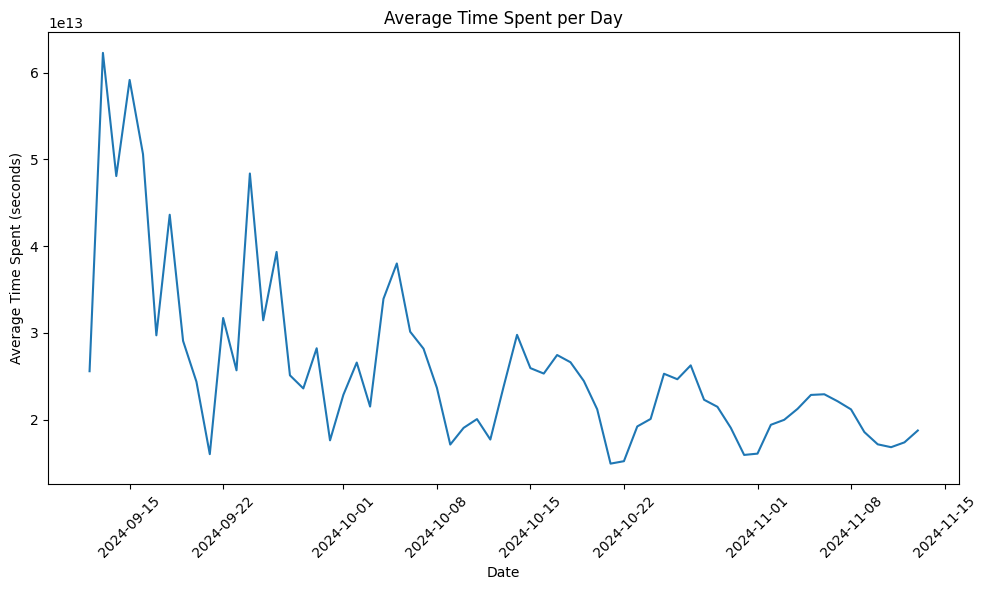

In [ ]:
merged_df = merged_df[merged_df['time_spent'] >= pd.Timedelta(0)]
print(merged_df.shape)

# Calculate average time spent per day
merged_df['date'] = merged_df['timestamp_entry'].dt.date
average_time_spent_per_day = merged_df.groupby('date')['time_spent'].mean()

# Plot time_spent against dates
plt.figure(figsize=(10, 6))
plt.plot(average_time_spent_per_day.index, average_time_spent_per_day.values)
plt.xlabel('Date')
plt.ylabel('Average Time Spent (seconds)')
plt.title('Average Time Spent per Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/

Model failed for parameters (p,d,q)=(0,1,7): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(0,1,8): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(0,1,9): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(0,1,10): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/

Model failed for parameters (p,d,q)=(1,1,7): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(1,1,8): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(1,1,9): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(1,1,10): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/

Model failed for parameters (p,d,q)=(2,1,7): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(2,1,8): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(2,1,9): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(2,1,10): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/

Model failed for parameters (p,d,q)=(3,1,7): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(3,1,8): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(3,1,9): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(3,1,10): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/

Model failed for parameters (p,d,q)=(4,1,7): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(4,1,8): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(4,1,9): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(4,1,10): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/

Model failed for parameters (p,d,q)=(5,1,7): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(5,1,8): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(5,1,9): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(5,1,10): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/

Model failed for parameters (p,d,q)=(6,1,7): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(6,1,8): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(6,1,9): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(6,1,10): Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.
Model failed for parameters (p,d,q)=(7,1,0): Invalid model: autoregressive lag(s) {7} are in both the seasonal and non-seasonal autoregressive components.
Model failed for parameters (p,d,q)=(7,1,1): Invalid model: autoregressive lag(s) {7} are in both the seasonal and non-seasonal autoregressive components.
Model failed for parameters (p,d,q)=(7,1,2): Invalid model: autoregre

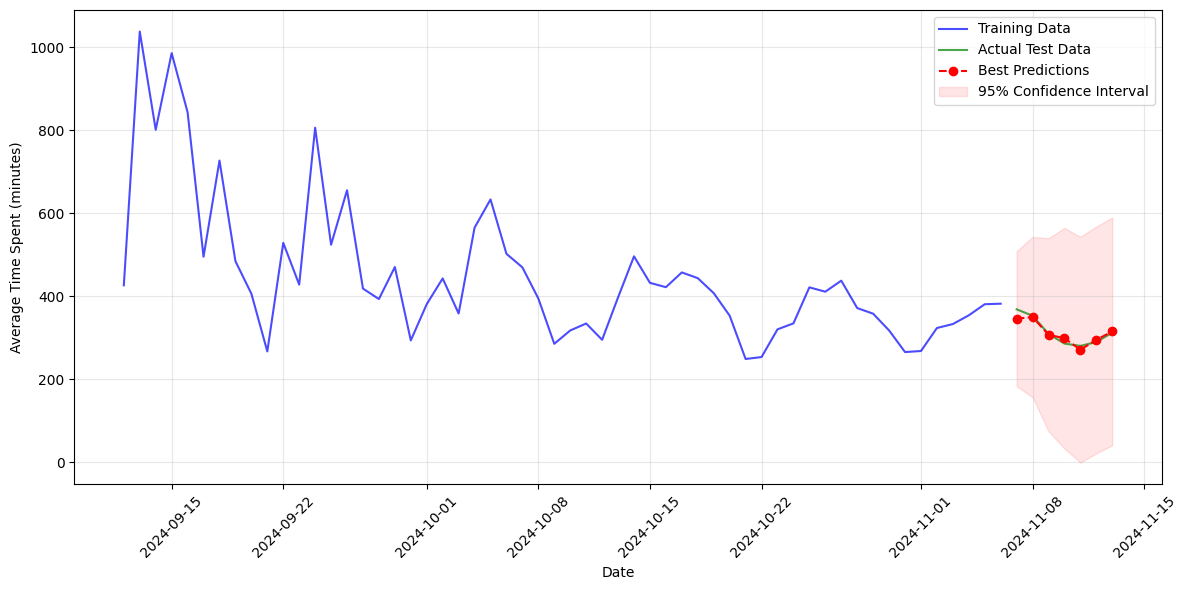

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

# Convert timedelta to minutes
average_time_spent = average_time_spent_per_day.dt.total_seconds() / 60
features = pd.DataFrame(index=pd.to_datetime(average_time_spent.index))
features['day_of_week'] = features.index.dayofweek
features['is_weekend'] = features['day_of_week'].isin([5, 6]).astype(int)

# Split data into train and test sets
train_data = average_time_spent[:-7]
test_data = average_time_spent[-7:]
train_features = features[:-7]
test_features = features[-7:]

# Track best model configuration
best_mape = float("inf")
best_mase = float("inf")
best_params = None
best_results = None
best_predicted_mean = None
best_conf_ints = None

# Calculate naive forecast for MASE
naive_forecast = train_data.shift(1)
naive_errors = np.abs(train_data - naive_forecast).dropna()
naive_mean_error = naive_errors.mean()

for p in range(11):
    for q in range(11):
        try:
            # Define the model
            model = SARIMAX(
                train_data,
                exog=train_features,
                order=(p, 1, q),
                seasonal_order=(1, 1, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False,
                suppress_warnings=True
            )

            # Fit the model
            results = model.fit(disp=False)
            predictions = results.get_forecast(
                steps=len(test_data),
                exog=test_features
            )
            predicted_mean = predictions.predicted_mean
            conf_ints = predictions.conf_int()

            # Calculate MAPE
            mape = mean_absolute_percentage_error(test_data, predicted_mean)

            # Calculate MASE
            mase = np.mean(np.abs(test_data - predicted_mean)) / naive_mean_error

            # Check if this model is the best so far
            if mape < best_mape and mase < best_mase:
                best_mape = mape
                best_mase = mase
                best_params = (p, 1, q)
                best_results = results
                best_predicted_mean = predicted_mean
                best_conf_ints = conf_ints

        except Exception as e:
            print(f"Model failed for parameters (p,d,q)=({p},1,{q}): {e}")
            continue

print(f"\nBest Model Parameters: (p,d,q)={best_params}")
print(f"Best MAPE: {best_mape:.2%}")
print(f"Best MASE: {best_mase:.2f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data,
         label='Training Data', color='blue', alpha=0.7)
plt.plot(test_data.index, test_data,
         label='Actual Test Data', color='green', alpha=0.7)
plt.plot(test_data.index, best_predicted_mean,
         label='Best Predictions', color='red',
         linestyle='--', marker='o')
plt.fill_between(test_data.index,
                 best_conf_ints.iloc[:, 0],
                 best_conf_ints.iloc[:, 1],
                 color='red', alpha=0.1,
                 label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Average Time Spent (minutes)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
print(best_predicted_mean, test_data)

2024-11-07    346.066056
2024-11-08    349.969100
2024-11-09    307.341495
2024-11-10    298.821372
2024-11-11    271.283331
2024-11-12    294.928601
2024-11-13    315.446883
Freq: D, Name: predicted_mean, dtype: float64 date
2024-11-07    368.677792
2024-11-08    353.127413
2024-11-09    309.511323
2024-11-10    285.997843
2024-11-11    280.493827
2024-11-12    289.772152
2024-11-13    312.562418
Name: time_spent, dtype: float64
